In [1]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
import nltk
import sys
import re, numpy as np, pandas as pd

In [3]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

In [5]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Loading file

In [6]:
import pickle

In [15]:
data = pd.read_pickle('top10_topic_dominant.pkl')

In [16]:
data.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.6574,"include, system, high, module, energy, low, pr...","[electrical, energy, system, include, electric..."
1,1,5.0,0.7450,"include, system, high, module, energy, low, pr...","[electrical, energy, system, include, electric..."
2,2,2.0,0.6005,"connect, unit, utility, controller, device, pr...","[regulate, circuit, microprocessor, regulator,..."
3,3,3.0,0.3726,"gear, part, transmission, clutch, axle, connec...","[drive, unit, electric, vehicle, comprise, ele..."
4,4,2.0,0.4033,"connect, unit, utility, controller, device, pr...","[drive, unit, electric, motor, car, comprise, ..."
5,5,2.0,0.5762,"connect, unit, utility, controller, device, pr...","[control, circuit, controller, provide, microp..."
6,6,1.0,0.6564,"battery, charge, voltage, system, converter, s...","[system, board, charge, battery, electrical, v..."
7,7,6.0,0.5615,"motor, drive, first, engine, second, speed, to...","[invention, drive, electric, vehicle, drive, s..."
8,8,9.0,0.5676,"fuel, cell, stack, water, fill, hydrogen, supp...","[method, thermal, management, fuel, cell, meth..."
9,9,9.0,0.5676,"fuel, cell, stack, water, fill, hydrogen, supp...","[method, thermal, management, fuel, cell, meth..."


In [19]:
data.Dominant_Topic.value_counts(ascending=True)

0.0      56
3.0     617
4.0     802
9.0    1673
7.0    1860
1.0    2828
8.0    3276
5.0    5038
2.0    8368
6.0    9705
Name: Dominant_Topic, dtype: int64

above table shows Number of patents applications within specific topic

# Calculating patent share

In [20]:
len(data)

34223

In [21]:
data.Dominant_Topic.value_counts(normalize=True)

6.0    0.283581
2.0    0.244514
5.0    0.147211
8.0    0.095725
1.0    0.082634
7.0    0.054349
9.0    0.048885
4.0    0.023435
3.0    0.018029
0.0    0.001636
Name: Dominant_Topic, dtype: float64

In [22]:
data.Dominant_Topic.mean()

4.7432428483768225

 # 2)-Trends in the number and the share of patents by topics
 
 (a) Change in the number of patents over filing year <br>
 (b) Change in the share of patents over filing year

### 2(a) Change in the number of patents over filing year

In [23]:
data_patent = pd.read_pickle('patent_orginal.pkl')
data_patent.head()

,appln,appln_id,family_id,sets,direct,granted,earliest_appln,earliest_filing_date,publn_date,publn,...,citing_publn_date,citing_publn,citing_appln,citing_appln_id,citing_family_id,num_citing_family,earliest_applt,current_applt,appln_title,appln_abstr
0,WO9105114W,47158713,1239277,2,1,1,US55592190A,1990-07-19,1993-02-18,WO9303532A1,...,2002-07-11,WO0199222A3,WO0119827W,45621927,24395918,30,LUZ ELECTRIC FUEL ISRAEL LTD.,LUZ ELECTRIC FUEL ISRAEL LTD.,ELECTRICAL ENERGY SYSTEM,An electrical energy system including an elect...
1,US55592190A,51797454,1239277,2,1,1,US55592190A,1990-07-19,1992-06-09,US5121044A,...,1993-05-04\n1994-03-09\n1994-09-20\n1995-07-18...,US5208526A\nEP0557287A4\nUS5349535A\nUS5434020...,US63645090A\nEP91915464A\nUS96399792A\nUS15296...,52393850\n16916549\n54353461\n48212422\n457802...,27071024\n1239277\n25508001\n22545199\n2636904...,30,"Luz Electric Fuel Israel, Ltd.","Luz Electric Fuel Israel, Ltd.",Electrical energy system,An electrical energy system including an elect...
2,DE19512512A,13386323,3505305,2,1,0,AT104194A,1994-05-20,1995-11-23,DE19512512A1,...,1999-04-14\n2003-02-27\n2007-05-22\n2011-05-05...,EP0834977A3\nDE10137908A1\nUS7221062B2\nWO2010...,EP97810450A\nDE10137908A\nUS48552204A\nWO20100...,17254227\n12994897\n51255594\n315713854\n33380...,4222203\n7694132\n7694132\n43298243\n44288075\...,4,"STEYR-DAIMLER-PUCH AG, WIEN, AT","STEYR-DAIMLER-PUCH AG, WIEN, AT",Regulating circuit for battery-operated electr...,The regulating circuit has a microprocessor re...
3,DE4417432A,11295467,3505504,2,1,0,AT105093A,1993-05-28,1994-12-01,DE4417432A1,...,1996-06-07\n1996-06-13\n1997-10-21\n1998-11-26...,FR2727654A1\nDE4442867A1\nUS5678646A\nDE197215...,FR9514218A\nDE4442867A\nUS56615095A\nDE1972152...,20508327\n11314571\n51875327\n13472609\n172965...,6534688\n6534688\n6534688\n7830237\n7831607\n7...,39,"STEYR-DAIMLER-PUCH AG, WIEN, AT","STEYR-DAIMLER-PUCH AG, WIEN, AT",Liquid-cooled drive unit for an electric vehicle,A drive unit for an electric vehicle comprises...
4,US25087194A,49013353,3505504,2,0,1,AT105093A,1993-05-28,1996-12-17,US5585681A,...,1998-08-27\n2001-03-06\n2002-10-02\n2003-03-05...,WO9828833A3\nUS6198183B1\nEP0951131A3\nEP12880...,WO9702146W\nUS29465599A\nEP99106967A\nEP020179...,43603749\n49378246\n17378403\n15912913\n487780...,20405163\n7865025\n7865025\n19091319\n19091319...,39,Steyr-Daimler Puch AG,Steyr-Daimler Puch AG,Liquid-cooled drive unit for an electric motor...,A drive unit for an electric motor car compris...


In [24]:
filling_date= data_patent.earliest_filing_date

In [25]:
data['application_date']= pd.to_datetime(filling_date)

In [26]:
data.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,application_date
0,0,5.0,0.6574,"include, system, high, module, energy, low, pr...","[electrical, energy, system, include, electric...",1990-07-19
1,1,5.0,0.7450,"include, system, high, module, energy, low, pr...","[electrical, energy, system, include, electric...",1990-07-19
2,2,2.0,0.6005,"connect, unit, utility, controller, device, pr...","[regulate, circuit, microprocessor, regulator,...",1994-05-20
3,3,3.0,0.3726,"gear, part, transmission, clutch, axle, connec...","[drive, unit, electric, vehicle, comprise, ele...",1993-05-28
4,4,2.0,0.4033,"connect, unit, utility, controller, device, pr...","[drive, unit, electric, motor, car, comprise, ...",1993-05-28


In [27]:
data.groupby(["application_date","Dominant_Topic"]).count().head(20)

Document_No  Topic_Perc_Contrib  Keywords  \
application_date Dominant_Topic                                              
1990-01-31       5.0                       1                   1         1   
1990-02-08       5.0                       2                   2         2   
1990-02-28       2.0                       1                   1         1   
                 6.0                       2                   2         2   
1990-03-08       3.0                       1                   1         1   
                 5.0                       2                   2         2   
1990-03-30       2.0                       1                   1         1   
1990-04-04       2.0                       2                   2         2   
1990-04-06       6.0                       3                   3         3   
1990-04-11       5.0                       1                   1         1   
1990-04-18       2.0                       2                   2         2   
                 6.0                       5                   5         5   
1990-04-27       1.0                       1                   1         1   
1990-04-30       2.0                       2                   2         2   
1990-05-16       2.0                       2                   2         2   
1990-05-17       2.0                       2                   2         2   
1990-05-18       8.0                       1                   1         1   
1990-05-23       5.0                       4                   4         4   
                 6.0                       1                   1         1   
1990-05-24       2.0                       4                   4         4   

                                 Text  
application_date Dominant_Topic        
1990-01-31       5.0                1  
1990-02-08       5.0                2  
1990-02-28       2.0                1  
                 6.0                2  
1990-03-08       3.0                1  
                 5.0                2  
1990-03-30       2.0                1  
1990-04-04       2.0                2  
1990-04-06       6.0                3  
1990-04-11       5.0                1  
1990-04-18       2.0                2  
                 6.0                5  
1990-04-27       1.0                1  
1990-04-30       2.0                2  
1990-05-16       2.0                2  
1990-05-17       2.0                2  
1990-05-18       8.0                1  
1990-05-23       5.0                4  
                 6.0                1  
1990-05-24       2.0                4

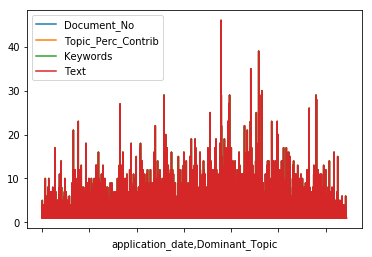

In [28]:
data.groupby(["application_date","Dominant_Topic"]).count().plot()

**The problem is occuring as it is taking mponths and days in application date as well. We need to use dt.year to focus only on year**

In [ ]:
data.dtypes

In [ ]:
data['application_date'].dt.year

In [ ]:
data.groupby(data.application_date.dt.year).Dominant_Topic.value_counts()

In [ ]:
data.groupby(data.application_date.dt.year).Dominant_Topic.value_counts().plot(kind='barh')

In [ ]:
data.groupby(data.application_date.dt.year).Dominant_Topic.count().plot()

In [ ]:
data.groupby(data.application_date.dt.year).Dominant_Topic.sum().plot()

# For rough work

In [29]:
topic=data['Dominant_Topic']
topic.head()

0    5.0
1    5.0
2    2.0
3    3.0
4    2.0
Name: Dominant_Topic, dtype: float64

In [30]:
data.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,application_date
0,0,5.0,0.6574,"include, system, high, module, energy, low, pr...","[electrical, energy, system, include, electric...",1990-07-19
1,1,5.0,0.7450,"include, system, high, module, energy, low, pr...","[electrical, energy, system, include, electric...",1990-07-19
2,2,2.0,0.6005,"connect, unit, utility, controller, device, pr...","[regulate, circuit, microprocessor, regulator,...",1994-05-20
3,3,3.0,0.3726,"gear, part, transmission, clutch, axle, connec...","[drive, unit, electric, vehicle, comprise, ele...",1993-05-28
4,4,2.0,0.4033,"connect, unit, utility, controller, device, pr...","[drive, unit, electric, motor, car, comprise, ...",1993-05-28


In [31]:
filling_date=data['application_date']
filling_date.head()

0   1990-07-19
1   1990-07-19
2   1994-05-20
3   1993-05-28
4   1993-05-28
Name: application_date, dtype: datetime64[ns]

In [32]:
filling_date.shape

(34223,)

In [33]:
df = pd.DataFrame({'TOPIC':topic,
                   'Filling_Date':filling_date})

In [34]:
df.head()

,TOPIC,Filling_Date
0,5.0,1990-07-19
1,5.0,1990-07-19
2,2.0,1994-05-20
3,3.0,1993-05-28
4,2.0,1993-05-28


Now get counts per category, per year:

In [35]:
ctdf = (df.reset_index()
          .groupby((df.Filling_Date.dt.year).TOPIC, as_index=False)
          .value_counts()
          # rename isn't strictly necessary here, it's just for readability
          .rename(columns={'index':'ct'})
       )

AttributeError: 'Series' object has no attribute 'TOPIC'

In [36]:
ctdf=df.groupby(df.Filling_Date.dt.year).TOPIC.value_counts()

In [37]:
ctdf.head()

Filling_Date  TOPIC
1990          2.0      29
              6.0      23
              5.0      21
              8.0       7
              3.0       3
Name: TOPIC, dtype: int64

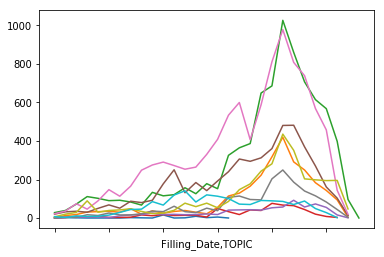

In [38]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

# key gives the group name (i.e. category), data gives the actual values
for key, data in ctdf.groupby('TOPIC'):
    data.plot(x='Filling_Date', y='ct', ax=ax, label=key)

In [39]:
data.groupby(data.application_date.dt.year).Dominant_Topic.value_counts()

AttributeError: 'Series' object has no attribute 'application_date'

In [40]:
df.groupby(df.Filling_Date.dt.year).TOPIC.value_counts()

Filling_Date  TOPIC
1990          2.0       29
              6.0       23
              5.0       21
              8.0        7
              3.0        3
              1.0        1
              4.0        1
              7.0        1
1991          2.0       40
              6.0       37
              5.0       33
              8.0       21
              1.0       14
              9.0        8
              4.0        5
              7.0        5
1992          6.0       75
              2.0       73
              5.0       36
              8.0       30
              1.0       19
              4.0        6
              7.0        4
              9.0        4
              3.0        3
1993          2.0      112
              8.0       90
              6.0       47
              1.0       32
              5.0       31
                      ... 
2015          2.0      568
              6.0      458
              8.0      195
              5.0      162
              1.0      144
        

In [41]:
# For year 2014 only, number of patent applications per topic
df.groupby(df.Filling_Date.dt.year==2014).TOPIC.value_counts()

Filling_Date  TOPIC
False         6.0      9136
              2.0      7753
              5.0      4767
              8.0      3077
              1.0      2644
              7.0      1744
              9.0      1584
              4.0       728
              3.0       572
              0.0        53
True          2.0       615
              6.0       569
              5.0       271
              8.0       199
              1.0       184
              7.0       116
              9.0        89
              4.0        74
              3.0        45
              0.0         3
Name: TOPIC, dtype: int64

### (b) Change in the share of patents over filing year

In [42]:
df.groupby(df.Filling_Date.dt.year).TOPIC.value_counts(normalize=True)

Filling_Date  TOPIC
1990          2.0      0.337209
              6.0      0.267442
              5.0      0.244186
              8.0      0.081395
              3.0      0.034884
              1.0      0.011628
              4.0      0.011628
              7.0      0.011628
1991          2.0      0.245399
              6.0      0.226994
              5.0      0.202454
              8.0      0.128834
              1.0      0.085890
              9.0      0.049080
              4.0      0.030675
              7.0      0.030675
1992          6.0      0.300000
              2.0      0.292000
              5.0      0.144000
              8.0      0.120000
              1.0      0.076000
              4.0      0.024000
              7.0      0.016000
              9.0      0.016000
              3.0      0.012000
1993          2.0      0.314607
              8.0      0.252809
              6.0      0.132022
              1.0      0.089888
              5.0      0.087079
                    

In [43]:
ctdf2=df.groupby(df.Filling_Date.dt.year).TOPIC.value_counts(normalize=True)

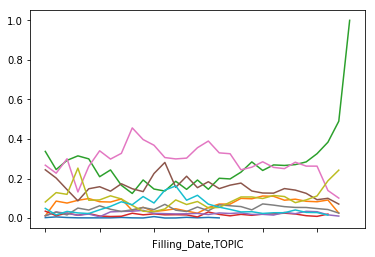

In [44]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

# key gives the group name (i.e. category), data gives the actual values
for key, data in ctdf2.groupby('TOPIC'):
    data.plot(x='Filling_Date', y='ct', ax=ax, label=key)

# 4)- Share of patents by  technological topics

table 3 in paper

In [49]:
# start with 2010
df.groupby(df.Filling_Date.dt.year==2010).TOPIC.value_counts()

Filling_Date  TOPIC
False         6.0      8894
              2.0      7682
              5.0      4677
              8.0      2994
              1.0      2510
              7.0      1656
              9.0      1581
              4.0       748
              3.0       577
              0.0        55
True          6.0       811
              2.0       686
              5.0       361
              1.0       318
              8.0       282
              7.0       204
              9.0        92
              4.0        54
              3.0        40
              0.0         1
Name: TOPIC, dtype: int64

2849 for 2010<br>
2849/34223=8.32 %

In [48]:
# For 2011
df.groupby(df.Filling_Date.dt.year==2011).TOPIC.value_counts()

Filling_Date  TOPIC
False         6.0      8727
              2.0      7342
              5.0      4557
              8.0      2840
              1.0      2408
              7.0      1610
              9.0      1583
              4.0       744
              3.0       540
              0.0        56
True          2.0      1026
              6.0       978
              5.0       481
              8.0       436
              1.0       420
              7.0       250
              9.0        90
              3.0        77
              4.0        58
Name: TOPIC, dtype: int64

for year 2010, we have told of 3816 which has patent share of <br>

3816/34223=11.15%

In [50]:
# for 2012
df.groupby(df.Filling_Date.dt.year==2012).TOPIC.value_counts()

Filling_Date  TOPIC
False         6.0      8897
              2.0      7508
              5.0      4556
              8.0      2924
              1.0      2536
              7.0      1673
              9.0      1586
              4.0       709
              3.0       549
              0.0        54
True          2.0       860
              6.0       808
              5.0       482
              8.0       352
              1.0       292
              7.0       187
              4.0        93
              9.0        87
              3.0        68
              0.0         2
Name: TOPIC, dtype: int64

For 2012, 3231 <br>
9.44%

In [51]:
# for 2013
df.groupby(df.Filling_Date.dt.year==2013).TOPIC.value_counts()

Filling_Date  TOPIC
False         6.0      8966
              2.0      7661
              5.0      4668
              8.0      3072
              1.0      2578
              7.0      1719
              9.0      1602
              4.0       744
              3.0       552
              0.0        46
True          6.0       739
              2.0       707
              5.0       370
              1.0       250
              8.0       204
              7.0       141
              9.0        71
              3.0        65
              4.0        58
              0.0        10
Name: TOPIC, dtype: int64

In [53]:
# for 2013, count function used instead of summing all one by one
df.groupby(df.Filling_Date.dt.year==2013).TOPIC.count()

Filling_Date
False    31608
True      2615
Name: TOPIC, dtype: int64

In [54]:
2615/34223

0.07641060105776817

In [55]:
# for 2014, count function used instead of summing all one by one
df.groupby(df.Filling_Date.dt.year==2014).TOPIC.count()

Filling_Date
False    32058
True      2165
Name: TOPIC, dtype: int64

In [56]:
2165/34223

0.06326154925050405

In [57]:
# for 2015, count function used instead of summing all one by one
df.groupby(df.Filling_Date.dt.year==2015).TOPIC.count()

Filling_Date
False    32479
True      1744
Name: TOPIC, dtype: int64

In [58]:
1744/34223

0.050959880781930283

In [59]:
# for 2016, count function used instead of summing all one by one
df.groupby(df.Filling_Date.dt.year==2016).TOPIC.count()

Filling_Date
False    33183
True      1040
Name: TOPIC, dtype: int64

In [60]:
1040/34223

0.030388919732343745

In [61]:
# for 2017, count function used instead of summing all one by one
df.groupby(df.Filling_Date.dt.year==2017).TOPIC.count()

Filling_Date
False    34025
True       198
Name: TOPIC, dtype: int64

In [62]:
198/34223

0.005785582795196213

In [63]:
# for 2018, count function used instead of summing all one by one
df.groupby(df.Filling_Date.dt.year==2018).TOPIC.count()

Filling_Date
False    34222
True         1
Name: TOPIC, dtype: int64

In [64]:
1/34223

2.92201151272536e-05

**The average patent share in 2012 by topic was 9.44%. So, we will take it as reference value to determine whether given patent is samll or large**

In [69]:
## for 2012
df.groupby(df.Filling_Date.dt.year==2012).TOPIC.value_counts()

Filling_Date  TOPIC
False         6.0      8897
              2.0      7508
              5.0      4556
              8.0      2924
              1.0      2536
              7.0      1673
              9.0      1586
              4.0       709
              3.0       549
              0.0        54
True          2.0       860
              6.0       808
              5.0       482
              8.0       352
              1.0       292
              7.0       187
              4.0        93
              9.0        87
              3.0        68
              0.0         2
Name: TOPIC, dtype: int64

In [70]:
df.groupby(df.Filling_Date.dt.year==2012).TOPIC.count()

Filling_Date
False    30992
True      3231
Name: TOPIC, dtype: int64

In [71]:
# For 2012,current patent share
df.groupby(df.Filling_Date.dt.year==2012).TOPIC.value_counts(normalize=True)

Filling_Date  TOPIC
False         6.0      0.287074
              2.0      0.242256
              5.0      0.147006
              8.0      0.094347
              1.0      0.081828
              7.0      0.053982
              9.0      0.051174
              4.0      0.022877
              3.0      0.017714
              0.0      0.001742
True          2.0      0.266171
              6.0      0.250077
              5.0      0.149180
              8.0      0.108945
              1.0      0.090374
              7.0      0.057877
              4.0      0.028784
              9.0      0.026927
              3.0      0.021046
              0.0      0.000619
Name: TOPIC, dtype: float64

### Calculate CAGR
https://www.investopedia.com/terms/c/cagr.asp

We will consider years from 2010-2014

In [72]:
df.groupby(df.Filling_Date.dt.year==2010).TOPIC.value_counts()

Filling_Date  TOPIC
False         6.0      8894
              2.0      7682
              5.0      4677
              8.0      2994
              1.0      2510
              7.0      1656
              9.0      1581
              4.0       748
              3.0       577
              0.0        55
True          6.0       811
              2.0       686
              5.0       361
              1.0       318
              8.0       282
              7.0       204
              9.0        92
              4.0        54
              3.0        40
              0.0         1
Name: TOPIC, dtype: int64

Initial values for patent share are given 

In [73]:
df.groupby(df.Filling_Date.dt.year==2015).TOPIC.value_counts()

Filling_Date  TOPIC
False         6.0      9247
              2.0      7800
              5.0      4876
              8.0      3081
              1.0      2684
              7.0      1776
              9.0      1623
              4.0       746
              3.0       596
              0.0        50
True          2.0       568
              6.0       458
              8.0       195
              5.0       162
              1.0       144
              7.0        84
              4.0        56
              9.0        50
              3.0        21
              0.0         6
Name: TOPIC, dtype: int64